In [1]:
import networkx as nx

In [2]:
def csvToList(filename):
    with open(filename,'r') as f:
        # allLine : CSV的每row變成一string的string list 
        # readlines後面的[1:]表示從第一行之後開始讀，也可以用next(f)達到這個目的
        allLines = f.readlines()[1:]  
        f.closed
        dataList = [] 
        for line in allLines: # line : CSV各row變成的string
            # line.split(',')將各line以','為單位分割，x.strip()是刪去分割後各element的前後空白符和換行符號
            item = [x.strip() for x in line.split(',')] 
            item = list(map(int, item))
            # 在dataList這個二維list中加入item這個list
            dataList.append(item) 
    return dataList    

def loadLists(nodeNum, dataList):
    dis = {}
    coor = {}
    netSupply = {}
    nodes = {}
    dummyNodes = {}
    for i in range(nodeNum):
        coor[i] = [dataList[i][1], dataList[i][2]]
        netSupply[i] = int(dataList[i][3])
        if dataList[i][4]==2:
            dummyNodes[i] = i
        else:
            nodes[i] = i
        for j in range(nodeNum):
            dis[i,j] = abs(dataList[i][1]-dataList[j][1]) + abs(dataList[i][2]-dataList[j][2])
    return coor, dis, netSupply, nodes, dummyNodes

In [3]:
def crossSet(nodeNum, coor):
    cross = []
    for i in range(nodeNum):
        for j in range(i+1, nodeNum):
            for k in range(i+1,nodeNum):
                for l in range(k+1, nodeNum):
                    if(judgeRectangleCoincide(coor[i], coor[j], coor[k], coor[l])):
                        cross.append([i,j,k,l])
    return cross

def judgeRectangleCoincide(a, b, c, d):
    if min(a[0],b[0])<max(c[0],d[0]) and min(c[1],d[1])<max(a[1],b[1]) and min(c[0],d[0])<max(a[0],b[0]) \
    and min(a[1],b[1])<max(c[1],d[1]):
        return judgeCross(a, b, c, d)
    else:
        return False
    
def judgeCross(a, b, c, d):
    u = (c[0]-a[0])*(b[1]-a[1]) - (b[0]-a[0])*(c[1]-a[1])
    v = (d[0]-a[0])*(b[1]-a[1]) - (b[0]-a[0])*(d[1]-a[1])
    w = (a[0]-c[0])*(d[1]-c[1]) - (d[0]-c[0])*(a[1]-c[1])
    z = (b[0]-c[0])*(d[1]-c[1]) - (d[0]-c[0])*(b[1]-c[1])
    return u*v<0 and w*z<0

In [7]:
from gurobipy import *
m = Model("mip1")
nodeList = csvToList('風機nodes_with more substation.csv')
nodeNum = len(nodeList)

coor, dis, netSupply, nodes, dummyNodes = loadLists(nodeNum, nodeList)
cross = crossSet(nodeNum, coor)
cables, cost, capacity = multidict({0: [0,0], 1: [5,1], 2: [6,2], 3:[7,3], 4:[10,4], 5:[11,5], \
                                    6:[14,6], 7:[15,7]})
cabNum = len(cables)

flow = {}
x = {}
y = {}

# add variables
for t in cables:
    for i in range(nodeNum):
        for j in range(nodeNum):
            flow[t,i,j] = m.addVar(vtype=GRB.INTEGER, name = 'flow_%s_%s_%s'%(t,i,j))
            x[t,i,j] = m.addVar(vtype=GRB.BINARY, name = 'x_%s_%s_%s'%(t,i,j))
            y[i,j] = m.addVar(vtype=GRB.BINARY, name = 'y_%s_%s'%(i,j))
    
# preset obstacles edge
y[30,31] = 1
y[31,33] = 1
y[32,30] = 1
y[33,32] = 1
m.update()

# flow balance
for i in range(nodeNum):
    m.addConstr(quicksum(flow[t,i,j] for t in cables for j in range(nodeNum))
                         -quicksum(flow[t,j,i] for t in cables for j in range(nodeNum)) >= netSupply[i], 'flowBal_%s'%(i))

# upper bound and lower bound with cables
for i in range(nodeNum):
    for j in range(nodeNum):
        for t in cables:
            m.addConstr(flow[t,i,j] == x[t,i,j]*capacity[t], 'upper_%s_%s_%s'%(t, i, j))

# each turbine can ouput by at most one cable
for i in range(nodeNum):
    m.addConstr(quicksum(x[t,i,j] for t in cables for j in range(nodeNum)) <= 1, 'oneOuput_%s'%(i))

# connection between x and y
for i in range(nodeNum):
    for j in range(nodeNum):
        m.addConstr(quicksum(x[t,i,j] for t in cables) ==  y[i,j], 'x%s_y%s_relation'%(i, j))
    
# no cross
for pair in cross:
    m.addConstr(y[pair[0],pair[1]] + y[pair[1],pair[0]] + y[pair[2],pair[3]] + y[pair[3],pair[2]] <= 1, \
                'noCross_(%s,%s)_(%s,%s)'%(pair[0],pair[1],pair[2],pair[3]))
        
m.setObjective(quicksum(x[t,i,j]*cost[t]*dis[i,j] for t in cables for i in range(nodeNum) for j in range(nodeNum)), GRB.MINIMIZE)

m.optimize()



Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 70623 rows, 36504 columns and 299684 nonzeros
Model fingerprint: 0x5c743505
Variable types: 0 continuous, 36504 integer (24336 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [5e+01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 12625.000000
Presolve removed 36279 rows and 28050 columns
Presolve time: 1.39s
Presolved: 34344 rows, 8454 columns, 178165 nonzeros
Variable types: 0 continuous, 8454 integer (8454 binary)

Root relaxation: objective 4.009286e+03, 213 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4009.28571    0   50 12625.0000 4009.28571  68.2%     -    1s
H    0     0                    5259.0000000 4009.28571  23.8%     -    1s
H    0     0                 

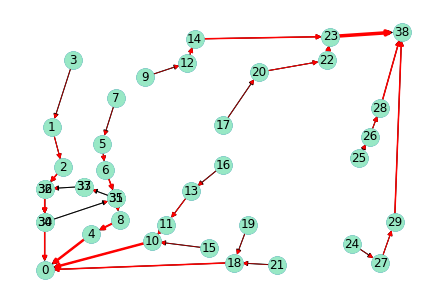

In [9]:
if m.status == GRB.Status.OPTIMAL:
    G = nx.DiGraph()
    cabList=[]
    for i in range(cabNum):
        temp=[]
        cabList.append(temp)

    for i in range(nodeNum):
        G.add_node(i, pos=(nodeList[i][1], nodeList[i][2]))
        for j in range(nodeNum):
            for t in cables:
                if x[t,i,j].x > 0:
                    G.add_edge(i, j)
                    cabList[t].append([i,j])
                    
    nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True)  
    nx.draw_networkx_edges(G, nx.get_node_attributes(G, 'pos'), width=1.0, alpha=0.5)
    nx.draw_networkx_nodes(G, nx.get_node_attributes(G, 'pos'), G.nodes(), node_color="#98e8c5")
    
    for i in range(cabNum):
        nx.draw_networkx_edges(
            G,
            nx.get_node_attributes(G, 'pos'),
            edgelist=cabList[i],
            width=i/2,
            alpha=1,
            edge_color="r",
        )